In [61]:
import pandas as pd
import numpy as np
import quandl
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt


from dateutil.parser import parse
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, precision_score, confusion_matrix, roc_auc_score
from sklearn.utils.multiclass import unique_labels


In [2]:
# pull in cleaned dataset

data = pd.read_csv('data/combined_clean.csv', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27492 entries, 0 to 27491
Data columns (total 45 columns):
Unnamed: 0              27492 non-null int64
ticker_symbol           27492 non-null object
co_name                 27492 non-null object
unique_earnings_code    27492 non-null object
factset_sector_num      27492 non-null float64
factset_ind_num         27492 non-null float64
calendar_qtr            27492 non-null object
fiscal_qtr              27492 non-null object
adtv_prev_month         27492 non-null object
report_date             27492 non-null object
eps_est                 27492 non-null object
eps_actual              27492 non-null object
surp_amt                27492 non-null object
rtn_t+3                 27492 non-null float64
mkt_t+3_rtn             27492 non-null float64
rel_t+3_rtn             27492 non-null float64
num_ests_qtr_end        27492 non-null float64
t-7_high_est            27492 non-null float64
t-7_low_est             27492 non-null float64
est_spread

In [6]:
def transform_dates(df, col_name):
    """Helper function to convert date columns to a sortable format"""
    dates = list(df[str(col_name)])
    new_dates = []

    for d in dates:
        dt = datetime.strptime(d, '%m/%d/%Y')
        reformatted = str(dt)
        reformatted = reformatted[:10]
        new_dates.append(reformatted)
        
    df[str(col_name)] = new_dates    

In [65]:
def partition_dataset(filename):
    data = pd.read_csv('data/'+str(filename)+'.csv', low_memory=False)
    data.drop(columns='Unnamed: 0', inplace=True)
    
    # reformat dates and sort by dates, ascending
    transform_dates(data, 'report_date')
    data.sort_values(by=['report_date'], inplace=True)
    
    # set index to unique_earnings_code
    data.set_index('unique_earnings_code', inplace=True)
    # partition 3q18 data to test set
    test_partition = data[data.index.str.endswith('3Q18')]
    
    # create y_oos array
    y_oos = test_partition.targets.values
    
    # create X_oos array
    features = test_partition.columns.str.endswith('F')
    X_oos = test_partition.values[:,features]
    
    # remove test_partition from data df
    data = data[data.index.str.endswith('3Q18') == False]
    
    # create y_train and X_train arrays
    y = data.targets.values
    X = data.values[:,features]
    
     
    return X, X_oos, y, y_oos


### FSM

In [66]:
X, X_oos, y, y_oos = partition_dataset('combined_clean')

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1970)

In [69]:
clf = RandomForestClassifier(n_estimators=500, 
                             criterion='gini',
                             max_features=5,
                             min_samples_split=5,
                             min_samples_leaf=5,
                             random_state=1970)

In [70]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=1970, verbose=0,
            warm_start=False)

In [71]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1970)

In [72]:
y_pred = clf.predict_proba(X_train)

In [73]:
cv_log_loss = cross_val_score(clf, # model
                             X_train, # Feature matrix
                             y_train, # Target vector
                             cv=skf, # Cross-validation technique
                             scoring="neg_log_loss", # Loss function
                             n_jobs=-1) # Use all CPU scores

In [74]:
cv_accuracy = cross_val_score(clf, # model
                             X_train, # Feature matrix
                             y_train, # Target vector
                             cv=skf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores

In [75]:
print(cv_log_loss)

[-0.32802341 -0.32980384 -0.32728928 -0.33078689 -0.3328173 ]


In [76]:
print(cv_accuracy)

[0.91205128 0.91205128 0.91251924 0.91251924 0.91251924]


In [77]:
print(y_pred)

[[0.9438444  0.05222372 0.00393188]
 [0.97668329 0.02202782 0.00128889]
 [0.91383895 0.07331634 0.01284471]
 ...
 [0.94218944 0.04590183 0.01190873]
 [0.99375842 0.00478773 0.00145385]
 [0.96905324 0.0180054  0.01294136]]


In [78]:
print(y_train)

[0 0 0 ... 0 0 0]


In [79]:
predicted_0 = y_pred[:,0]
predicted_1 = y_pred[:,1]
predicted_2 = y_pred[:,2]

In [80]:
short_signals = predicted_1 > .20
long_signals = predicted_2 > .20

In [81]:
sum(short_signals) / len(y_pred)

0.06945726890325228

In [82]:
sum(long_signals) / len(y_pred)

0.010208269211039294

In [85]:
data = data[data.index.str.endswith('3Q18') == False]

In [86]:
big_moves = data.extreme_targets.values

In [87]:
big_moves

array([0, 0, 0, ..., 0, 1, 0])

In [102]:
precision_score(y_train, hard_classes, average='micro')

0.9890222632604904

In [89]:
def _predict_ones(array):
    output = []
    for i in array:
        if i == 1:
            output.append(1)
        else:
            output.append(0)
    return np.array(output)

In [92]:
one_predictions = _predict_ones(hard_classes)

In [93]:
target_ones = _predict_ones(y_train)

In [104]:
def interpret_predictions(prob_array):
    hard_classes = []
    for row in prob_array:
        if row[0] > 0.80:
            hard_classes.append(0)
        elif row[1] >= 0.20:
            hard_classes.append(1)
        elif row[2] >= 0.20:
            hard_classes.append(2)
        else:
            hard_classes.append(0)
    return hard_classes
            

In [105]:
hard_classes = np.array(interpret_predictions(y_pred))

In [108]:
accurate_classifications = hard_classes == y_train

In [109]:
print(accurate_classifications)

[ True  True  True ...  True  True  True]


In [110]:
len(accurate_classifications)

19494

In [115]:
wrong_classifications = accurate_classifications[accurate_classifications == False]

In [116]:
len(wrong_classifications)

214

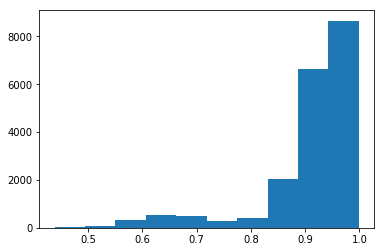

In [99]:
_ = plt.hist(predicted_0)

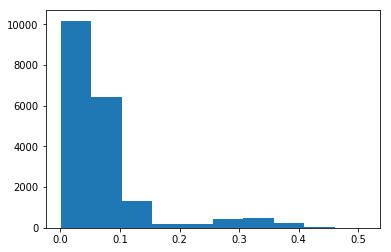

In [100]:
_ = plt.hist(predicted_1)

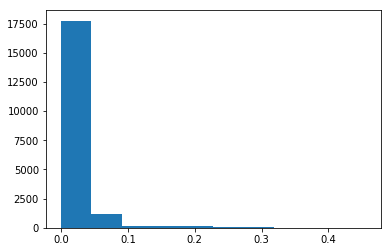

In [101]:
_ = plt.hist(predicted_2)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### Experimenting with Quancha API 

In [ ]:
def add_vol_slope(df):
    """docstring"""
    
    # quandl authentication
    quandl.ApiConfig.api_key = "jUKZLy5xi7gGFf3sSF-r"
    
    

In [ ]:
quandl.ApiConfig.api_key = "jUKZLy5xi7gGFf3sSF-r"

In [ ]:
toy = data.iloc[:25,:]

In [ ]:
toy

In [ ]:
dates = list(toy['report_date'])

In [ ]:
dates[0]

In [ ]:
dt = datetime.strptime(dates[0], '%m/%d/%Y')
str(dt)

In [ ]:
new_dates = []

for d in dates:
    dt = datetime.strptime(d, '%m/%d/%Y')
    reformatted = str(dt)
    reformatted = reformatted[:10]
    new_dates.append(reformatted)





In [ ]:
new_dates